In [1]:
# Импортируем основные библиотеки

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))"""

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

"""DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн"""

df_train = pd.read_csv('hotels_train.csv.zip')
df_test = pd.read_csv('hotels_test.csv.zip')
sample_submission = pd.read_csv('submission.csv.zip')

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_7560\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## `NaN` есть только в столбцах `lat` и `lng`, сейчас максимально трудоёмким и тупым способом найдём координаты данных отелей на Google Maps и обновим данные в таблице

In [7]:
# посмотрим адреса и названия отелей с пропусками координат
data[data['lat'].isnull() == True][['hotel_address','hotel_name']].value_counts()

hotel_address                                                hotel_name                                      
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria  Fleming s Selection Hotel Wien City                 658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria          Hotel City Central                                  563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria     Hotel Atlanta                                       389
4 rue de la P pini re 8th arr 75008 Paris France             Maison Albar Hotel Paris Op ra Diamond              290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria       Hotel Daniel Vienna                                 245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria        Hotel Pension Baron am Schottentor                  223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria             Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria          Derag Livi

In [8]:
# С помощью Google Maps найдём координаты этих отелей (можно было бы использовать более изящный вариант, но у меня лапки)
hotels = pd.DataFrame({'hotel_address':[
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
    '4 rue de la P pini re 8th arr 75008 Paris France',
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
    'Bail n 4 6 Eixample 08010 Barcelona Spain',
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
    '23 Rue Damr mont 18th arr 75018 Paris France',
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
    '20 Rue De La Ga t 14th arr 75014 Paris France',
    'Pau Clar s 122 Eixample 08009 Barcelona Spain',
    'Sep lveda 180 Eixample 08011 Barcelona Spain'], 'lat':[
    
    48.209910,
    48.21360,
    48.22036,
    48.87532,
    48.18888,
    48.21700,
    48.21975,
    48.24614,
    41.39181,
    48.22163,
    48.20971,
    48.20973,
    48.88910,
    48.18814,
    48.84012,
    41.39272,
    41.38340], 'lng':[
    
    16.353425,
    16.37988,
    16.35580,
    2.32338,
    16.38377,
    16.35989,
    16.28565,
    16.34153,
    2.17784,
    16.36641,
    16.35145,
    16.35148,
    2.33310,
    16.42049,
    2.32357,
    2.16739,
    2.16294]
})
hotels

,hotel_address,lat,lng
0,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.20991,16.353425
1,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.21360,16.379880
2,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.22036,16.355800
3,4 rue de la P pini re 8th arr 75008 Paris France,48.87532,2.323380
4,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,48.18888,16.383770
5,W hringer Stra e 12 09 Alsergrund 1090 Vienna ...,48.21700,16.359890
6,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,48.21975,16.285650
7,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,48.24614,16.341530
8,Bail n 4 6 Eixample 08010 Barcelona Spain,41.39181,2.177840
9,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.22163,16.366410


In [9]:
# C помощью волшебства, которое я нашел на stackoverflow обновим пропущенные данные 
data = (data.merge(hotels, on='hotel_address', how='left', suffixes=('','\x00')).sort_index(axis=1).bfill(axis=1)[data.columns])

In [10]:
# Проверим на NaN
cols_null_percent =  data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Series([], dtype: float64)

In [11]:
# Приведем дату к формату Datetime
data['review_date'] = pd.to_datetime(data['review_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  object        
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  object        
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  object        
 8   total_number_of_reviews                     515738 non-null  object       

## После обновления данных, все столбцы стали object'ами, вернём всё как было

In [12]:
data = data.infer_objects()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

<AxesSubplot:>

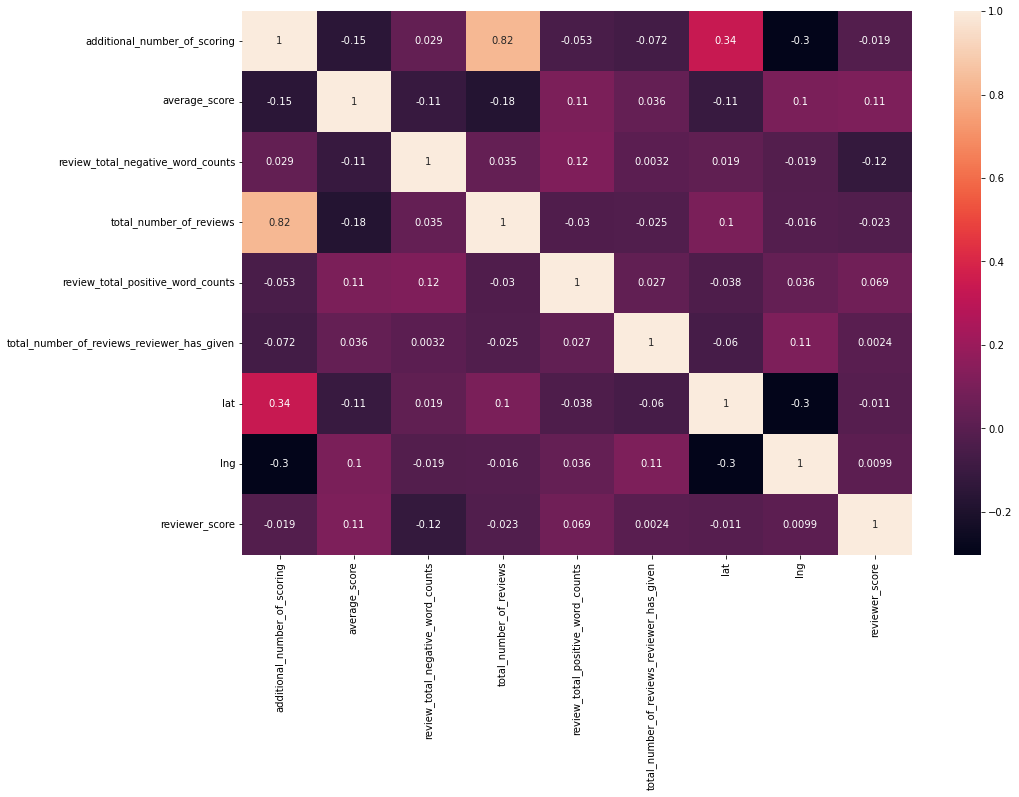

In [13]:
# Посмотрим на корреляции признаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

## На данном этапе закроем глаза на мультиколлениарность признаков "additional_number_of_scoring" и "total_number_of_reviews". Попробуем что-нибудь полезное сделать с object'ами

* `hotel_address` - (уникальных 1493) - попробуем выделить страну и закодировать получившиеся значения
* `hotel_name` - (1492 уникальных) - пока мысль просто дропнуть названия
* `reviewer_nationality` - (227 уникальных) - попробуем взять топ-5 самых частых национальностей рецензентов и закодировать их
* `negative_review` - (330011 уникальных) - уже есть количественные признаки (количество слов в отзыве) пока хз что делать с данным признаком
* `positive_review` - (412601 уникальных) - уже есть количественные признаки (количество слов в отзыве) пока хз что делать с данным признаком
* `tags` - (55242 уникальных) - можно попробовать выделить наиболее часто встречающиеся слова
* `days_since_review` - 731 уникальных) -

In [14]:
def country_extractor(data): # Достанем из адреса страну
    if data.split(sep=' ')[-1] == 'Kingdom':
        return ''.join(data.split(sep=' ')[-2::])
    else:
        return data.split(sep=' ')[-1]

# Перезапишем в признак hotel_address только страну 
data['hotel_counrty'] = data['hotel_address'].apply(country_extractor)
data['hotel_counrty'].describe()

count            515738
unique                6
top       UnitedKingdom
freq             262301
Name: hotel_counrty, dtype: object

In [15]:
def city_extractor(data): # Достанем из адреса город
    if data.split(sep=' ')[-1] == 'Kingdom':
        return ''.join(data.split(sep=' ')[-5])
    else:
        return data.split(sep=' ')[-2]

# Перезапишем в признак hotel_address только страну 
data['hotel_city'] = data['hotel_address'].apply(city_extractor)
data['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

## Ого, так тут и городов тоже 6, класс, тоже закодием (страну можно будет дропнуть), а ещё можно вычислить расстояние от отеля до центра города.

In [16]:
cities = pd.DataFrame({'hotel_city':[
    'London',
    'Barcelona',
    'Paris',
    'Amsterdam',
    'Vienna',
    'Milan'], 'city_lat':[
    
    51.507322,
    41.382894,
    48.853495,
    52.372760,
    48.208354,
    45.464194], 'city_lng':[
    
    -0.127647,
    2.177432,
    2.348391,
    4.893604,
    16.372504,
    9.189635]
})
cities

,hotel_city,city_lat,city_lng
0,London,51.507322,-0.127647
1,Barcelona,41.382894,2.177432
2,Paris,48.853495,2.348391
3,Amsterdam,52.372760,4.893604
4,Vienna,48.208354,16.372504
5,Milan,45.464194,9.189635


In [17]:
# Добавим в таблицу данные по центрам городов
data = data.merge(cities, on='hotel_city', how='left')
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_counrty,hotel_city,city_lat,city_lng
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,45.464194,9.189635
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,52.372760,4.893604
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,41.382894,2.177432


In [18]:
# добавим признак 'coordinates' состоящий из координат сначала отеля, потом центра города в котором расположен этот отель.
data['coordinates'] = list(zip(data['lat'], data['lng'], data['city_lat'], data['city_lng']))
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,lat,lng,sample,reviewer_score,hotel_counrty,hotel_city,city_lat,city_lng,coordinates
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,13 days,45.533137,9.171102,0,0.0,Italy,Milan,45.464194,9.189635,"(45.5331372, 9.1711019, 45.464194, 9.189635)"
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,52.372760,4.893604,"(52.3856494, 4.834443, 52.37276, 4.893604)"
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,41.382894,2.177432,"(41.3931918, 2.16152, 41.382894, 2.177432)"


In [19]:
# добавим признак расстояние от центра города.
import geopy

def distance_finder(data): #
    coord_1 = data[:2]
    coord_2 = data[-2:]
    return geopy.distance.geodesic(coord_1, coord_2).km

data['distance_from_center'] = data['coordinates'].apply(distance_finder)

data.head(5)

AttributeError: module 'geopy' has no attribute 'distance'